# Training and Validation

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import display, clear_output

%matplotlib inline

## Source Data for Well Structured Problem

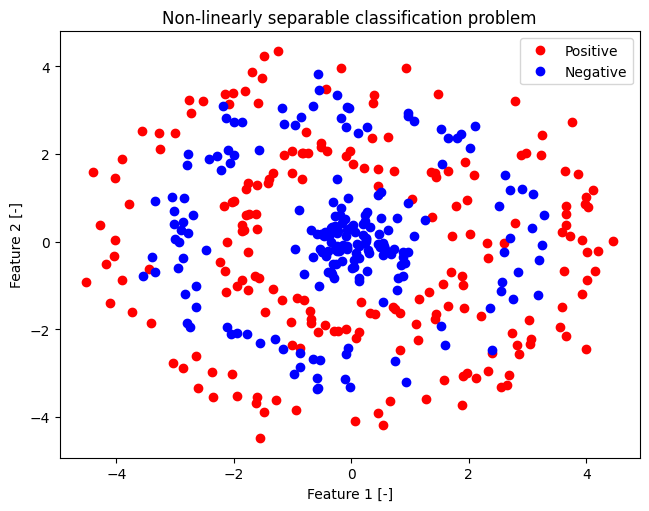

In [2]:
num_positive = 200
num_negative = 200
np.random.seed(101)

r_positive_inner = np.random.normal(2, 0.3, num_positive // 2)
r_positive_outer = np.random.normal(4, 0.3, num_positive // 2)
theta_positive = np.random.uniform(0, 2 * np.pi, num_positive)
data_positive = np.concatenate([
    np.column_stack((r_positive_inner * np.cos(theta_positive[:num_positive // 2]),
                     r_positive_inner * np.sin(theta_positive[:num_positive // 2]))),
    np.column_stack((r_positive_outer * np.cos(theta_positive[num_positive // 2:]),
                     r_positive_outer * np.sin(theta_positive[num_positive // 2:])))
])

r_negative_ring = np.random.normal(3, 0.3, num_negative // 2)
theta_negative_ring = np.random.uniform(0, 3 * np.pi, num_negative // 2)
data_negative_ring = np.column_stack((r_negative_ring * np.cos(theta_negative_ring),
                                       r_negative_ring * np.sin(theta_negative_ring)))
data_negative_center = np.random.normal(0, 0.5, (num_negative // 2, 2))  # Adjusting size to fit
data_negative = np.concatenate([data_negative_ring, data_negative_center])

# Plot the data
plt.plot(data_positive[:, 0], data_positive[:, 1], "ro", label="Positive")
plt.plot(data_negative[:, 0], data_negative[:, 1], "bo", label="Negative")
plt.tight_layout()
plt.legend()
plt.xlabel("Feature 1 [-]")
plt.ylabel("Feature 2 [-]")
plt.title("Non-linearly separable classification problem")
plt.show()

## Simplified Data Handling

In this simplified example, we do not use PyTorch's `Dataset` and `DataLoader` utilities. This approach is feasible because:

- We perform only a single data split.
- The entire dataset and model can fit into the computer's memory.

### Reshape Data
Merge the data and add labels:

In [3]:
# Create labels: 1 for positive and 0 for negative
labels_positive = np.ones(data_positive.shape[0])
labels_negative = np.zeros(data_negative.shape[0])

# Combine the positive and negative data
data_all = np.concatenate([data_positive, data_negative])
labels_all = np.concatenate([labels_positive, labels_negative])

### Split data

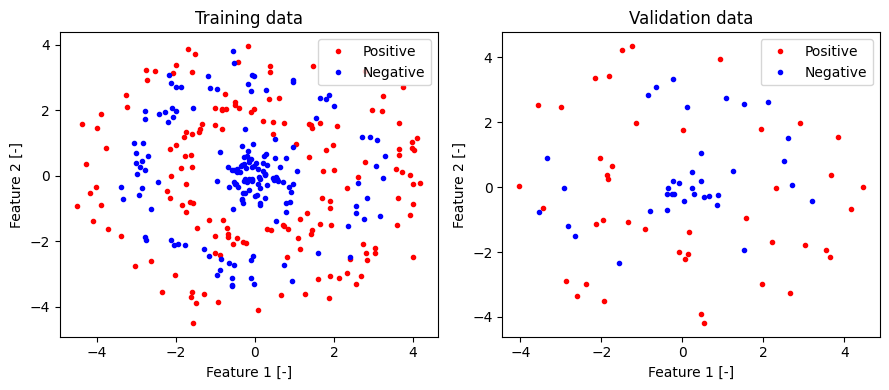

In [4]:
# Split the data into training and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(data_all, labels_all, test_size=0.2, random_state=101)


to_plot = (
    (121, "Training data", data_train, labels_train),
    (122, "Validation data", data_val, labels_val),
)

plt.figure(figsize=(9,4))
for subplot_idx, title, data, labels in to_plot:
    plt.subplot(subplot_idx)
    data_display = data[labels == 1]
    plt.plot(data_display[:,0], data_display[:,1], "r.", label="Positive")
    data_display = data[labels == 0]
    plt.plot(data_display[:,0], data_display[:,1], "b.", label="Negative")
    plt.title(title)
    plt.legend(); plt.xlabel("Feature 1 [-]"); plt.ylabel("Feature 2 [-]")    
plt.tight_layout()
plt.show()

### Prepare data tensors

In [5]:
train_inputs = torch.from_numpy(data_train).float()
train_targets = torch.from_numpy(labels_train).float()

val_inputs = torch.from_numpy(data_val).float()
val_targets = torch.from_numpy(labels_val).float()

## Model and Training

### Model Design

- The model architecture is defined within the constructor (`__init__`).
- A `forward` function is implemented, which is necessary for PyTorch to execute the model.

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input layer (2 features)
        self.fc2 = nn.Linear(64, 128)  # Hidden layer
        self.fc3 = nn.Linear(128, 64)  # Hidden layer
        self.fc4 = nn.Linear(64, 1)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Pass through first layer and apply ReLU
        x = self.relu(self.fc2(x))  # Pass through second layer and apply ReLU
        x = self.relu(self.fc3(x))  # Pass through third layer and apply ReLU
        x = torch.sigmoid(self.fc4(x))  # Output layer (sigmoid for binary classification)
        return x.squeeze(-1)

### Training Workflow

1. **Get data** (we already have them)
2. **Forward pass** through the model
3. **Compute loss**
4. **Backward pass** (calculate gradients from loss)
5. **Optimize model** (update weights using the optimizer)


In [8]:
# Instantiate the model
model = SimpleNN()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
       
    # Forward pass
    outputs = model(train_inputs)

    # Loss calculation
    loss = criterion(outputs, train_targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every x epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {loss.item():.4f}')

Epoch [0/1000], Training Loss: 0.6889
Epoch [100/1000], Training Loss: 0.0543
Epoch [200/1000], Training Loss: 0.0311
Epoch [300/1000], Training Loss: 0.0193
Epoch [400/1000], Training Loss: 0.0101
Epoch [500/1000], Training Loss: 0.0630
Epoch [600/1000], Training Loss: 0.0283
Epoch [700/1000], Training Loss: 0.0198
Epoch [800/1000], Training Loss: 0.0157
Epoch [900/1000], Training Loss: 0.0119


### Simple Inference and Validation

Once the model is trained, it can be used to predict classes. To save resources during inference, it is recommended to use `model.eval()` and `torch.no_grad()`.

In [18]:
model.eval()
with torch.no_grad():
    input_sample = torch.tensor([2, 4]).float()
    prediction = model(input_sample)
prediction.item()

0.9999998807907104

We can also pass a whole batch of samples and make the validation:

In [19]:
with torch.no_grad():
    predictions = model(val_inputs)
predictions = (predictions > 0.5).float() 

cm = confusion_matrix(val_targets.numpy(), predictions.numpy())  # Convert tensors to numpy arrays

print("Confusion Matrix:")
print(f"              Pred Class 0   Pred Class 1")
print(f"Actual Class 0    |   {cm[0, 0]}            {cm[0, 1]}")
print(f"Actual Class 1    |   {cm[1, 0]}            {cm[1, 1]}")

Confusion Matrix:
              Pred Class 0   Pred Class 1
Actual Class 0    |   32            5
Actual Class 1    |   4            39


### Analysis of the Trained Model

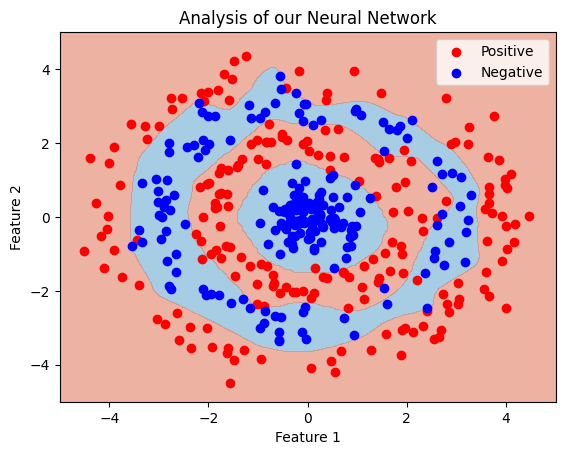

In [11]:
# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    pred_grid = model(grid_tensor)
    pred_grid = pred_grid.view(xx.shape)

plt.contourf(xx, yy, pred_grid, levels=[0, 0.5, 1], cmap='RdBu_r', alpha=0.6)
plt.scatter(data_positive[:, 0], data_positive[:, 1], c='red', label='Positive')
plt.scatter(data_negative[:, 0], data_negative[:, 1], c='blue', label='Negative')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Analysis of our Neural Network")
plt.show()

### More Proper Training with Validation

Epoch [0/1000], Training Loss: 0.70283,  Validation Loss: 0.69487
Epoch [100/1000], Training Loss: 0.45693,  Validation Loss: 0.51289
Epoch [200/1000], Training Loss: 0.15924,  Validation Loss: 0.25364
Epoch [300/1000], Training Loss: 0.05475,  Validation Loss: 0.22126
Epoch [400/1000], Training Loss: 0.03014,  Validation Loss: 0.26196
Epoch [500/1000], Training Loss: 0.02071,  Validation Loss: 0.30415
Epoch [600/1000], Training Loss: 0.01396,  Validation Loss: 0.34601
Epoch [700/1000], Training Loss: 0.01015,  Validation Loss: 0.38385
Epoch [800/1000], Training Loss: 0.00755,  Validation Loss: 0.41588
Epoch [900/1000], Training Loss: 0.00564,  Validation Loss: 0.44624


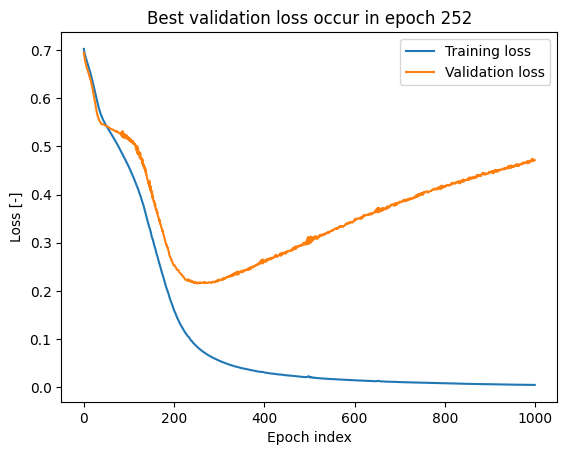

In [12]:
# Re-Instantiate the model
model = SimpleNN()

criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for epoch in range(epochs):
    # Training
    model.train()
    train_outputs = model(train_inputs)
    train_loss = criterion(train_outputs, train_targets)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    val_outputs = model(val_inputs)
    val_loss = criterion(val_outputs, val_targets)
    
    # Print loss every x epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_loss.item():.5f},  Validation Loss: {val_loss.item():.5f}')

    # Save for later
    train_losses[epoch], val_losses[epoch] = train_loss, val_loss

plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.show()

### Model Decision Boundary Animation

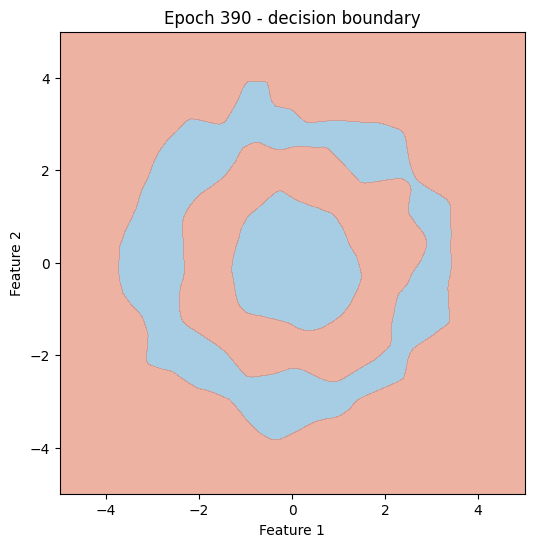

In [13]:
# Re-Instantiate the model
model = SimpleNN()

criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 400

# Create the figure and axis outside the loop to reuse
fig, ax = plt.subplots(figsize=(6,6))

# Plot initialization - set up mesh grid and contour plot
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Initialize the contour plot with dummy data (empty array)
contour = ax.contourf(xx, yy, np.zeros(xx.shape), levels=[0, 0.5, 1], cmap='RdBu_r', alpha=0.6)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Analysis of our Neural Network")

# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    train_outputs = model(train_inputs)
    train_loss = criterion(train_outputs, train_targets)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    val_outputs = model(val_inputs)
    val_loss = criterion(val_outputs, val_targets)

    # Print loss every x epochs
    if epoch % 10 == 0:
        # Make prediction
        with torch.no_grad():
            pred_grid = model(grid_tensor)
            pred_grid = pred_grid.view(xx.shape)

        clear_output(wait=True)
        for c in contour.collections:
            c.remove()
        contour = ax.contourf(xx, yy, pred_grid.numpy(), levels=[0, 0.5, 1], cmap='RdBu_r', alpha=0.6)
        ax.set_title(f"Epoch {epoch} - decision boundary")
        display(fig)  
        plt.pause(0.3)  
